In [113]:
import gzip         # for reading .pkl.gz
import pickle       # to load the pickled dicts
import numpy as np  # for arrays, math
import matplotlib.pyplot as plt  # for plotting
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap
from scipy.signal import find_peaks, peak_prominences, peak_widths
import matplotlib.cm as cm
import colormaps as cmaps
from colormaps.utils import show_cmaps_collection
from scipy.optimize import curve_fit



In [2]:
def mesh_index_to_km(x):
    return (x / 299) * 110

def km_to_mesh_index(x):
    return (x / 110) * 299

# Maximum Accumulation

Grounding Line Plot - Amax = 5


In [3]:
gl_run_title_amax5 = str("Grounding Line Evolution Over Time - Max Accumulation = 5 m/yr")
amax5 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_16__15_13_21.pkl.gz"
with gzip.open(amax5, 'rb') as f:
    DATA_dict_amax5 = pickle.load(f)

In [4]:
bed_dict = DATA_dict_amax5['bed_dict']
base_dict = DATA_dict_amax5['base_dict']
surf_dict= DATA_dict_amax5 ['surf_dict']
sed_dict = DATA_dict_amax5['sed_dict']
H_dict = DATA_dict_amax5['H_dict']
us_dict_5 = DATA_dict_amax5['us_dict']
ub_dict_5 = DATA_dict_amax5['ub_dict']
Hs_dict = DATA_dict_amax5['Hs_dict']
GL_dict = DATA_dict_amax5['GL_dict']
Qs_dict = DATA_dict_amax5['Qs_dict']

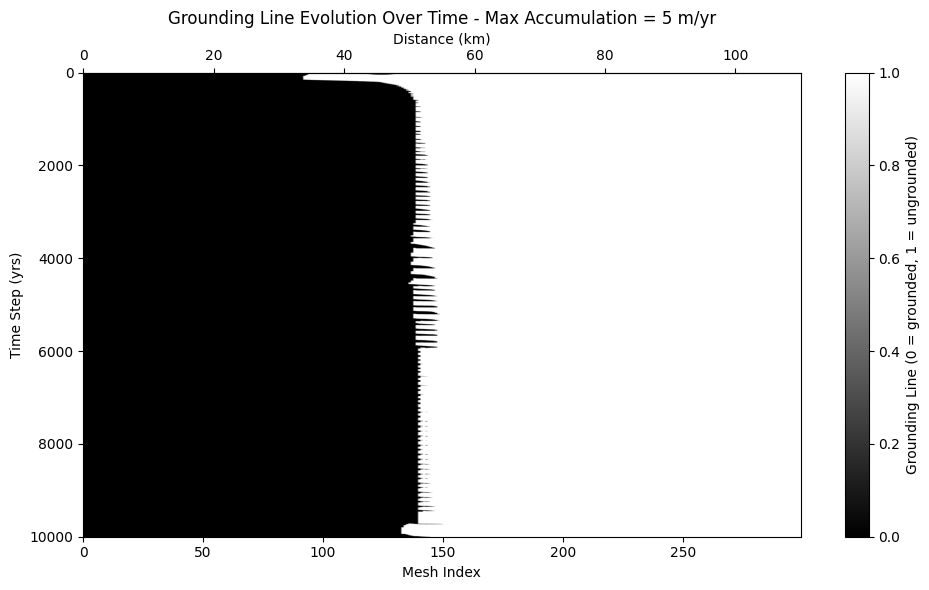

In [5]:
GL_dict = DATA_dict_amax5['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax5)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [6]:
gl_positions_amax5 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax5.append(idx)

gl_positions_amax5 = np.array(gl_positions_amax5)
GL_km_amax5 = mesh_index_to_km(gl_positions_amax5)



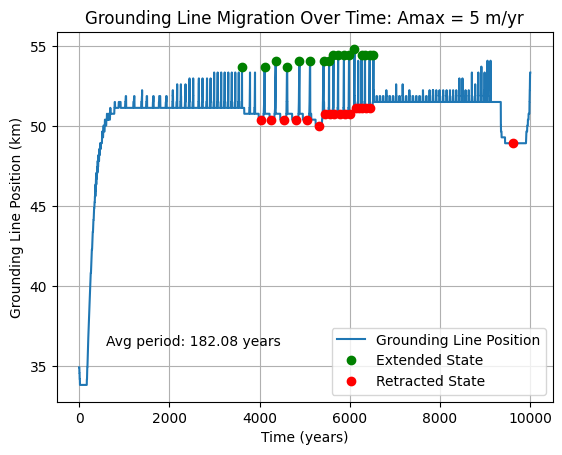

Mean cycle period: 182.08 years
[501.5696122  245.92848278 252.60618359 273.46352772 235.5396799
 301.31419611 120.49268564  98.20193177 103.0416729  127.62550512
 112.69708692 121.60835994 156.58010199  76.18826828 101.95987669
  84.52490585]
Mean advance amplitude: 54.23 km
[53.71237458 53.71237458 54.08026756 53.71237458 54.08026756 54.08026756
 54.08026756 54.08026756 54.44816054 54.44816054 54.44816054 54.44816054
 54.81605351 54.44816054 54.44816054 54.44816054 54.44816054]
Mean retreat amplitude: 50.63 km
[50.40133779 50.40133779 50.40133779 50.40133779 50.40133779 50.03344482
 50.76923077 50.76923077 50.76923077 50.76923077 50.76923077 50.76923077
 51.13712375 51.13712375 51.13712375 51.13712375 51.13712375 48.92976589]


In [7]:
peaks_amax5, _ = find_peaks(GL_km_amax5, prominence=3) 
troughs_amax5, _ = find_peaks(-GL_km_amax5, prominence=3)     
periods_amax5 = np.diff(np.array(time)[peaks_amax5])
adv_dists_amax5 = GL_km_amax5[peaks_amax5]
ret_dists_amax5 = GL_km_amax5[troughs_amax5]


plt.plot(time, GL_km_amax5, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax5], GL_km_amax5[peaks_amax5], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax5], GL_km_amax5[troughs_amax5], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax5):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 5 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax5):.2f} years")
print(periods_amax5)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax5):.2f} km")
print(adv_dists_amax5)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax5):.2f} km")
print(ret_dists_amax5)


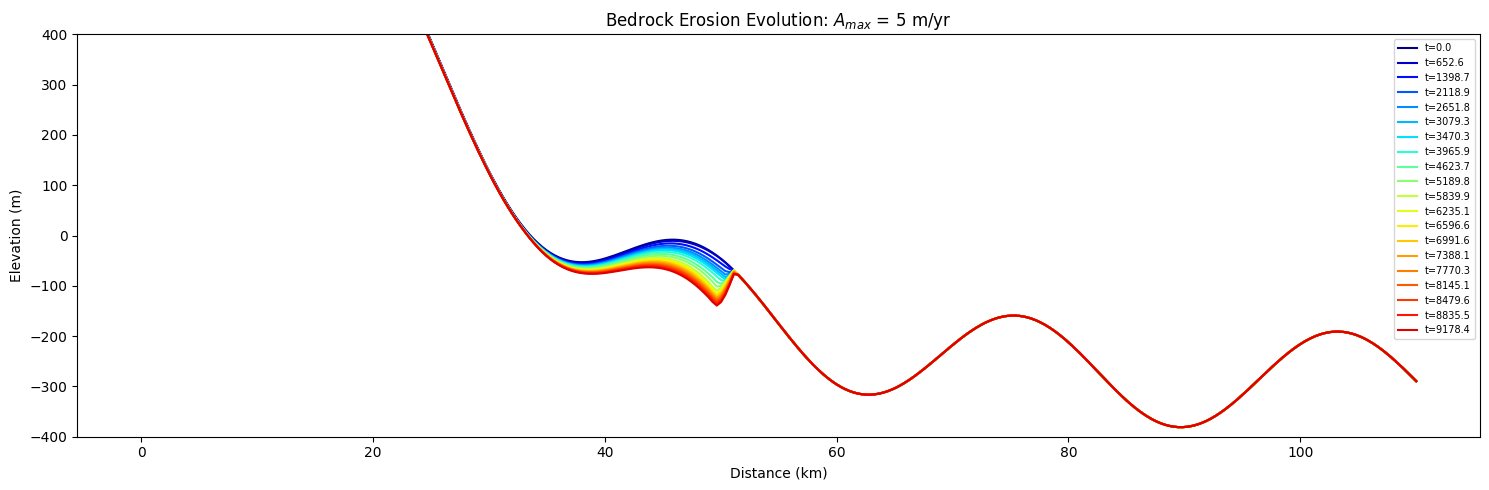

In [8]:
bed_dict = DATA_dict_amax5['bed_dict']
num_points = len(next(iter(bed_dict.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict.keys())
# bed_profile = bed_dict[timesteps[0]] 
norm = plt.Normalize(min(time), max(time))
cmap = cm.jet

fig, ax1 = plt.subplots(figsize=(15,5))

for i, t in enumerate(time):
    if i % 400 != 0:  
        continue

    bed = bed_dict[t]
    color = cmap(norm(t))
    plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Bedrock Erosion Evolution: $A_{max}$ = 5 m/yr")
# plt.gca().invert_xaxis() 
plt.legend(loc="upper right", fontsize=7)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# plt.xlim(30,100)
plt.ylim(-400,400)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()
# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/Amax/GL_Plots/Relationship_Plots/Bedrock_Evo_amax5.svg", format ="svg", bbox_inches='tight')

3060.1516948897897


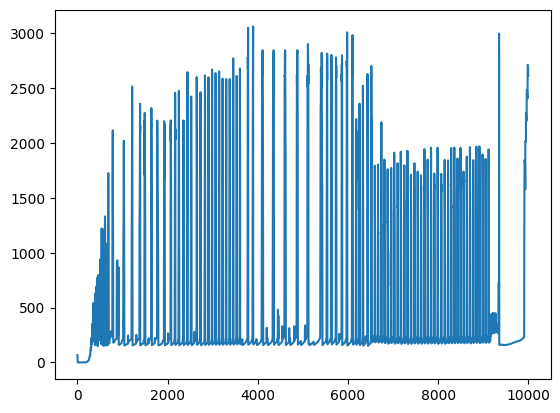

In [9]:
max_Qs_5 = np.array([max(values) for values in Qs_dict.values()])
time_5 = np.array(list(Qs_dict.keys()))

mask = time_5 <= 10000

time_5 = time_5[mask]
max_Qs_5 = max_Qs_5[mask]
plt.plot(time_5, max_Qs_5)
MAX_5 = np.max(max_Qs_5)

# MAX_21 = np.median(max_Qs_5)
print(MAX_5)

Grounding Line Plot - Amax = 6


In [10]:
gl_run_title_amax6 = str("Grounding Line Evolution Over Time - Max Accumulation = 6 m/yr")
amax6 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_16__14_32_19.pkl.gz"
with gzip.open(amax6, 'rb') as f:
    DATA_dict_amax6 = pickle.load(f)

In [11]:
bed_dict = DATA_dict_amax6['bed_dict']
base_dict = DATA_dict_amax6['base_dict']
surf_dict= DATA_dict_amax6 ['surf_dict']
sed_dict = DATA_dict_amax6['sed_dict']
H_dict = DATA_dict_amax6['H_dict']
us_dict_6 = DATA_dict_amax6['us_dict']
ub_dict_6 = DATA_dict_amax6['ub_dict']
Hs_dict = DATA_dict_amax6['Hs_dict']
GL_dict = DATA_dict_amax6['GL_dict']
Qs_dict_6 = DATA_dict_amax6['Qs_dict']

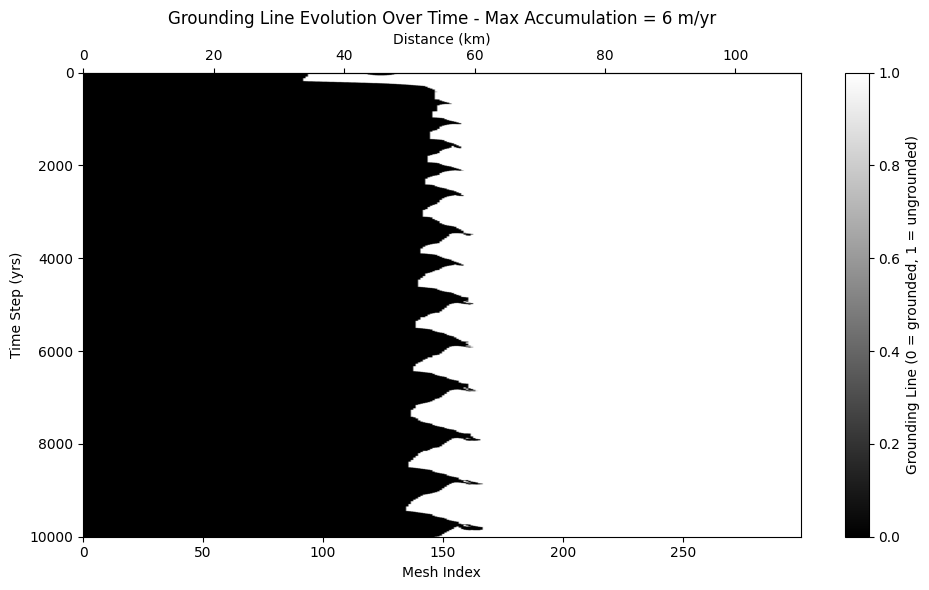

In [12]:
GL_dict = DATA_dict_amax6['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax6)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [13]:
gl_positions_amax6 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax6.append(idx)

gl_positions_amax6 = np.array(gl_positions_amax6)
GL_km_amax6 = mesh_index_to_km(gl_positions_amax6)



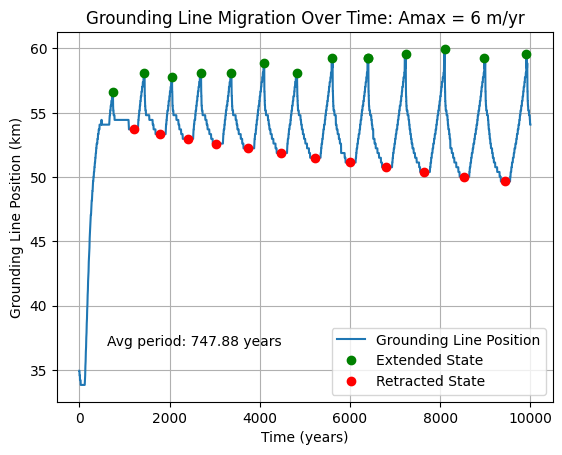

Mean cycle period: 747.88 years
[585.90012266 608.51821797 628.16260979 717.49280001 728.72610003
 742.44887894 783.3704132  799.09169006 853.84796089 875.46550764
 903.61087638]
Mean advance amplitude: 58.71 km
[56.65551839 58.1270903  57.75919732 58.1270903  58.1270903  58.86287625
 58.1270903  59.23076923 59.23076923 59.23076923 59.59866221 59.96655518
 59.23076923 59.59866221]
Mean retreat amplitude: 51.69 km
[53.71237458 53.34448161 52.97658863 52.60869565 52.24080268 51.8729097
 51.50501672 51.13712375 50.76923077 50.40133779 50.03344482 49.66555184]


In [14]:
peaks_amax6, _ = find_peaks(GL_km_amax6, prominence=2) 
troughs_amax6, _ = find_peaks(-GL_km_amax6, prominence=2)     
periods_amax6 = np.diff(np.array(time)[troughs_amax6])
adv_dists_amax6 = GL_km_amax6[peaks_amax6]
ret_dists_amax6 = GL_km_amax6[troughs_amax6]


plt.plot(time, GL_km_amax6, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax6], GL_km_amax6[peaks_amax6], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax6], GL_km_amax6[troughs_amax6], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax6):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 6 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax6):.2f} years")
print(periods_amax6)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax6):.2f} km")
print(adv_dists_amax6)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax6):.2f} km")
print(ret_dists_amax6)


3060.1516948897897


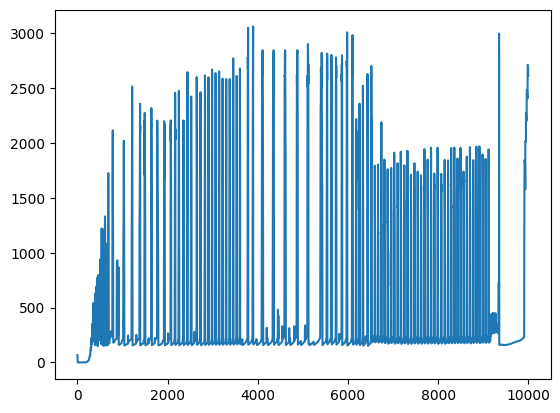

In [15]:
max_Qs_6 = np.array([max(values) for values in Qs_dict.values()])
time_6 = np.array(list(Qs_dict.keys()))

mask = time_6 <= 10000

time_6 = time_6[mask]
max_Qs_6 = max_Qs_6[mask]
plt.plot(time_6, max_Qs_6)
MAX_6 = np.max(max_Qs_6)

# MAX_21 = np.median(max_Qs_55)
print(MAX_6)

Grounding Line Plot - Amax = 6.5


In [16]:
gl_run_title_amax6_5 = str("Grounding Line Evolution Over Time - Max Accumulation = 6.5 m/yr")
amax6_5 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_20__18_34_46.pkl.gz"
with gzip.open(amax6_5, 'rb') as f:
    DATA_dict_amax6_5 = pickle.load(f)

In [17]:
bed_dict = DATA_dict_amax6_5['bed_dict']
base_dict = DATA_dict_amax6_5['base_dict']
surf_dict= DATA_dict_amax6_5 ['surf_dict']
sed_dict = DATA_dict_amax6_5['sed_dict']
H_dict = DATA_dict_amax6_5['H_dict']
us_dict_65 = DATA_dict_amax6_5['us_dict']
ub_dict_65 = DATA_dict_amax6_5['ub_dict']
Hs_dict = DATA_dict_amax6_5['Hs_dict']
GL_dict = DATA_dict_amax6_5['GL_dict']
Qs_dict_65 = DATA_dict_amax6_5['Qs_dict']

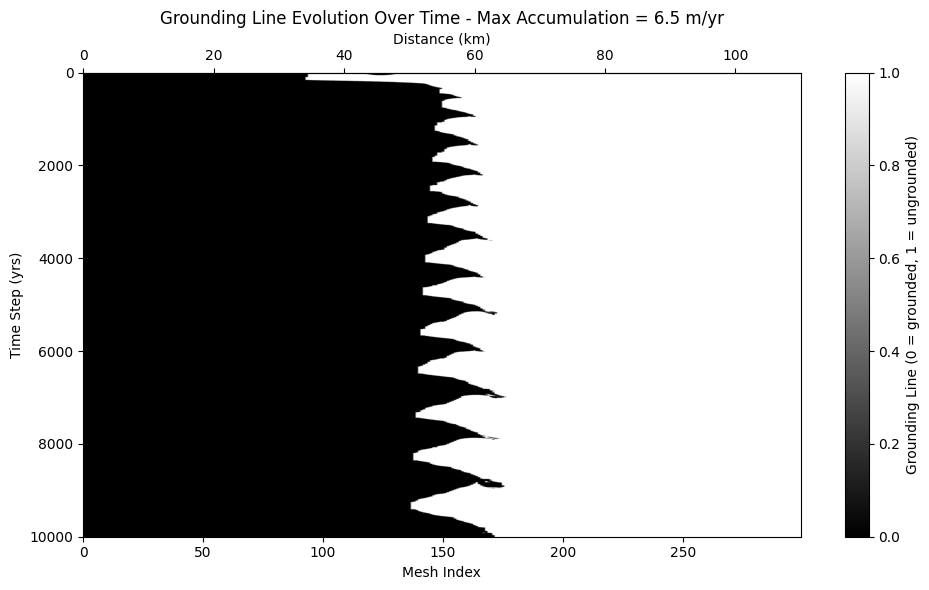

In [18]:
GL_dict = DATA_dict_amax6_5['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax6_5)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [19]:
gl_positions_amax6_5 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax6_5.append(idx)

gl_positions_amax6_5 = np.array(gl_positions_amax6_5)
GL_km_amax6_5 = mesh_index_to_km(gl_positions_amax6_5)



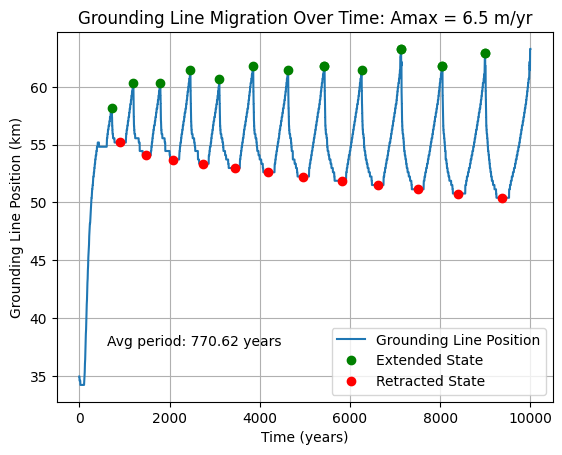

Mean cycle period: 770.62 years
[588.68278352 591.5500721  677.14156913 702.9693872  728.12264065
 781.7901545  860.69510003 805.70107669 889.56979272 878.27237737
 972.29179754]
Mean advance amplitude: 61.58 km
[58.1270903  60.33444816 60.33444816 61.43812709 60.70234114 61.80602007
 61.43812709 61.80602007 61.80602007 61.43812709 63.27759197 63.27759197
 61.80602007 61.80602007 62.909699   62.909699  ]
Mean retreat amplitude: 52.49 km
[55.18394649 54.08026756 53.71237458 53.34448161 52.97658863 52.60869565
 52.24080268 51.8729097  51.50501672 51.13712375 50.76923077 50.40133779]


In [20]:
peaks_amax6_5, _ = find_peaks(GL_km_amax6_5, prominence=2) 
troughs_amax6_5, _ = find_peaks(-GL_km_amax6_5, prominence=2)     
periods_amax6_5 = np.diff(np.array(time)[troughs_amax6_5])
adv_dists_amax6_5 = GL_km_amax6_5[peaks_amax6_5]
ret_dists_amax6_5 = GL_km_amax6_5[troughs_amax6_5]


plt.plot(time, GL_km_amax6_5, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax6_5], GL_km_amax6_5[peaks_amax6_5], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax6_5], GL_km_amax6_5[troughs_amax6_5], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax6_5):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 6.5 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax6_5):.2f} years")
print(periods_amax6_5)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax6_5):.2f} km")
print(adv_dists_amax6_5)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax6_5):.2f} km")
print(ret_dists_amax6_5)


3060.1516948897897


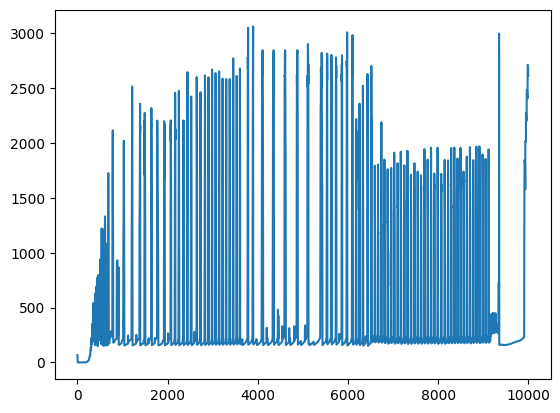

In [21]:
max_Qs_65 = np.array([max(values) for values in Qs_dict.values()])
time_65 = np.array(list(Qs_dict.keys()))

mask = time_65 <= 10000

time_65 = time_65[mask]
max_Qs_65 = max_Qs_65[mask]
plt.plot(time_65, max_Qs_65)
MAX_65 = np.max(max_Qs_65)

# MAX_21 = np.median(max_Qs_6)
print(MAX_65)

Grounding Line Plot - Amax = 7


In [22]:
gl_run_title_amax7 = str("Grounding Line Evolution Over Time - Max Accumulation = 7 m/yr")
amax7 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_16__13_37_56.pkl.gz"
with gzip.open(amax7, 'rb') as f:
    DATA_dict_amax7 = pickle.load(f)

In [23]:
bed_dict = DATA_dict_amax7['bed_dict']
base_dict = DATA_dict_amax7['base_dict']
surf_dict= DATA_dict_amax7 ['surf_dict']
sed_dict = DATA_dict_amax7['sed_dict']
H_dict = DATA_dict_amax7['H_dict']
us_dict_7 = DATA_dict_amax7['us_dict']
ub_dict_7 = DATA_dict_amax7['ub_dict']
Hs_dict = DATA_dict_amax7['Hs_dict']
GL_dict = DATA_dict_amax7['GL_dict']
Qs_dict_7 = DATA_dict_amax7['Qs_dict']

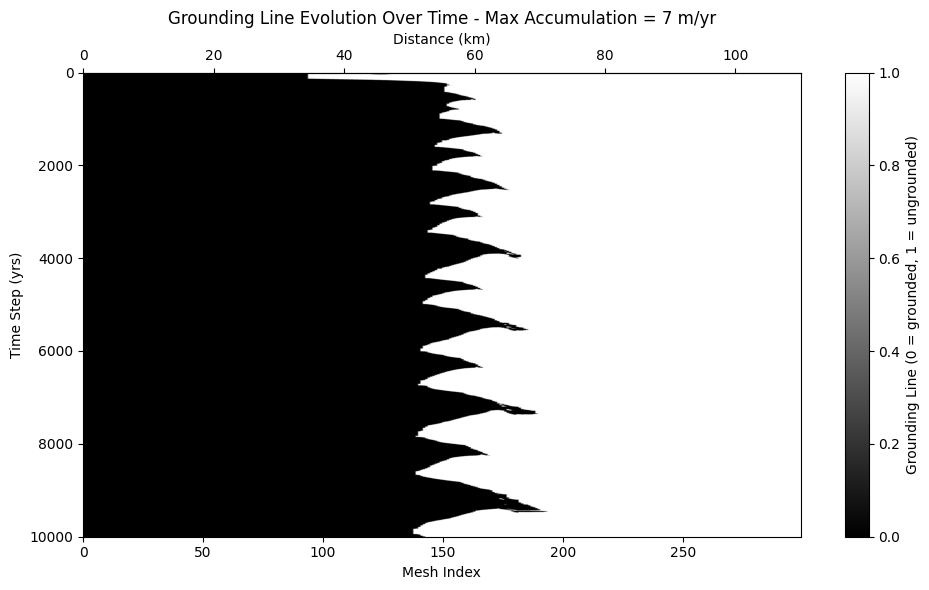

In [24]:
GL_dict = DATA_dict_amax7['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax7)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [25]:
gl_positions_amax7 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax7.append(idx)

gl_positions_amax7 = np.array(gl_positions_amax7)
GL_km_amax7 = mesh_index_to_km(gl_positions_amax7)



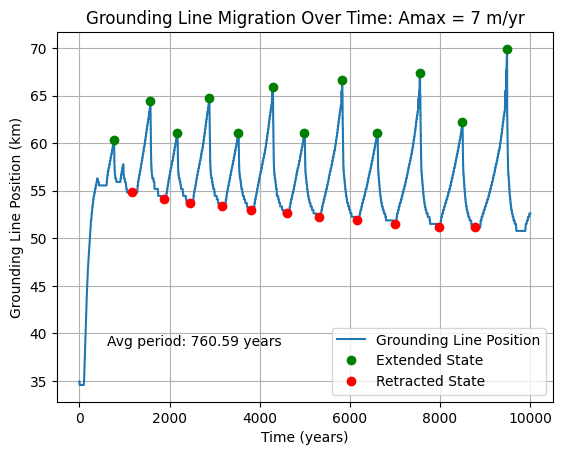

Mean cycle period: 760.59 years
[692.12719463 584.77687439 710.65467113 640.46758012 794.59509144
 720.5205055  846.51051578 830.56094612 982.29411453 803.36494387]
Mean advance amplitude: 63.80 km
[60.33444816 64.3812709  61.07023411 64.74916388 61.07023411 65.85284281
 61.07023411 66.58862876 61.07023411 67.32441472 62.17391304 69.89966555]
Mean retreat amplitude: 52.68 km
[54.81605351 54.08026756 53.71237458 53.34448161 52.97658863 52.60869565
 52.24080268 51.8729097  51.50501672 51.13712375 51.13712375]


In [26]:
peaks_amax7, _ = find_peaks(GL_km_amax7, prominence=3) 
troughs_amax7, _ = find_peaks(-GL_km_amax7, prominence=3)     
periods_amax7 = np.diff(np.array(time)[troughs_amax7])
adv_dists_amax7 = GL_km_amax7[peaks_amax7]
ret_dists_amax7 = GL_km_amax7[troughs_amax7]


plt.plot(time, GL_km_amax7, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax7], GL_km_amax7[peaks_amax7], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax7], GL_km_amax7[troughs_amax7], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax7):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 7 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax7):.2f} years")
print(periods_amax7)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax7):.2f} km")
print(adv_dists_amax7)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax7):.2f} km")
print(ret_dists_amax7)


3060.1516948897897


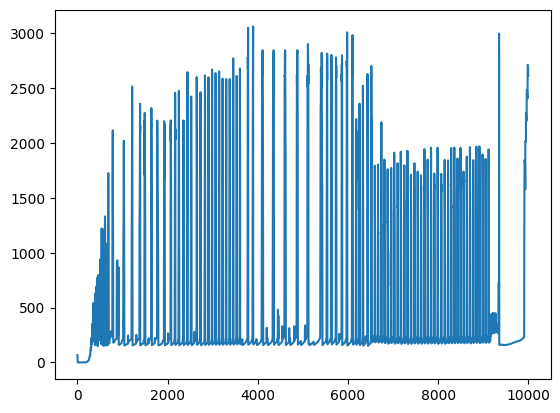

In [27]:
max_Qs_7 = np.array([max(values) for values in Qs_dict.values()])
time_7 = np.array(list(Qs_dict.keys()))

mask = time_7 <= 10000

time_7 = time_7[mask]
max_Qs_7 = max_Qs_7[mask]
plt.plot(time_7, max_Qs_7)
MAX_7 = np.max(max_Qs_7)

# MAX_21 = np.median(max_Qs_7)
print(MAX_7)

Grounding Line Plot - Amax = 7.5


In [28]:
gl_run_title_amax7_5 = str("Grounding Line Evolution Over Time - Max Accumulation = 7.5 m/yr")
amax7_5 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_20__20_43_15.pkl.gz"
with gzip.open(amax7_5, 'rb') as f:
    DATA_dict_amax7_5 = pickle.load(f)

In [29]:
bed_dict = DATA_dict_amax7_5['bed_dict']
base_dict = DATA_dict_amax7_5['base_dict']
surf_dict= DATA_dict_amax7_5['surf_dict']
sed_dict = DATA_dict_amax7_5['sed_dict']
H_dict = DATA_dict_amax7_5['H_dict']
us_dict_75 = DATA_dict_amax7_5['us_dict']
ub_dict_75 = DATA_dict_amax7_5['ub_dict']
Hs_dict = DATA_dict_amax7_5['Hs_dict']
GL_dict = DATA_dict_amax7_5['GL_dict']
Qs_dict_75 = DATA_dict_amax7_5['Qs_dict']

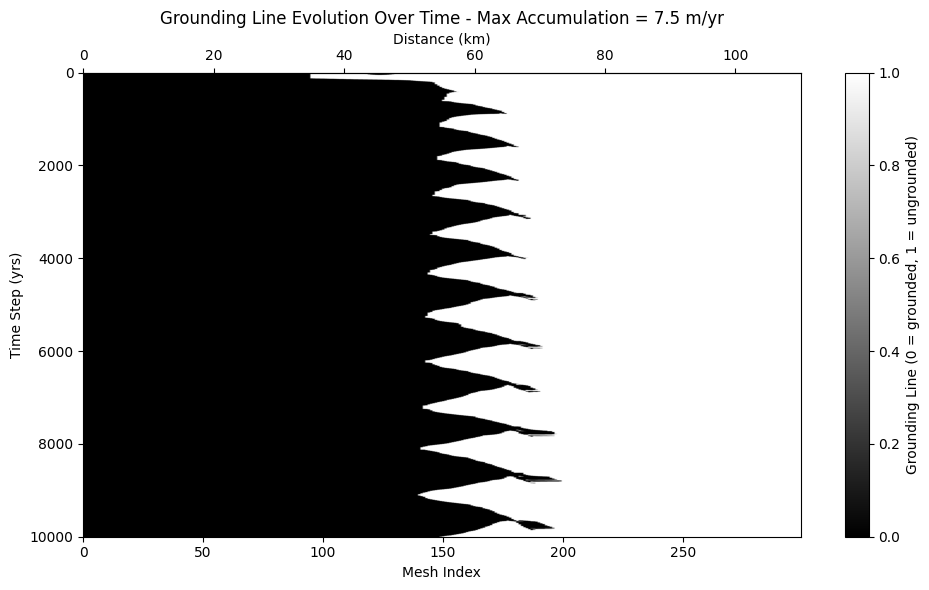

In [30]:
GL_dict = DATA_dict_amax7_5['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax7_5)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [31]:
gl_positions_amax7_5 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax7_5.append(idx)

gl_positions_amax7_5 = np.array(gl_positions_amax7_5)
GL_km_amax7_5 = mesh_index_to_km(gl_positions_amax7_5)



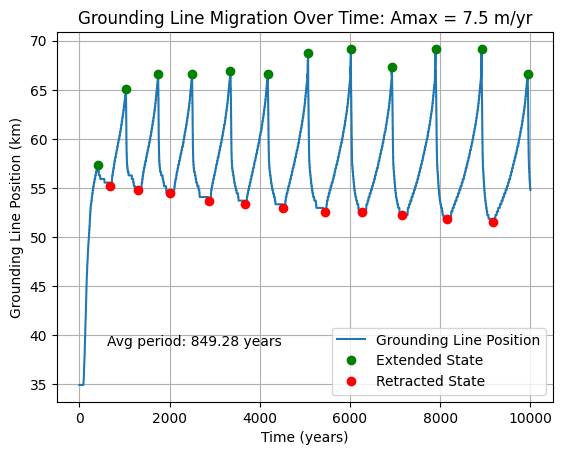

Mean cycle period: 849.28 years
[ 615.07762706  708.37354252  871.34692188  801.72440853  840.91396855
  920.90029844  837.21168292  881.51260406  998.93416843 1016.78187095]
Mean advance amplitude: 66.62 km
[57.39130435 65.11705686 66.58862876 66.58862876 66.95652174 66.58862876
 68.79598662 69.1638796  67.32441472 69.1638796  69.1638796  66.58862876]
Mean retreat amplitude: 53.21 km
[55.18394649 54.81605351 54.44816054 53.71237458 53.34448161 52.97658863
 52.60869565 52.60869565 52.24080268 51.8729097  51.50501672]


In [32]:
peaks_amax7_5, _ = find_peaks(GL_km_amax7_5, prominence=2) 
troughs_amax7_5, _ = find_peaks(-GL_km_amax7_5, prominence=2)     
periods_amax7_5 = np.diff(np.array(time)[troughs_amax7_5])
adv_dists_amax7_5 = GL_km_amax7_5[peaks_amax7_5]
ret_dists_amax7_5 = GL_km_amax7_5[troughs_amax7_5]


plt.plot(time, GL_km_amax7_5, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax7_5], GL_km_amax7_5[peaks_amax7_5], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax7_5], GL_km_amax7_5[troughs_amax7_5], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax7_5):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 7.5 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax7_5):.2f} years")
print(periods_amax7_5)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax7_5):.2f} km")
print(adv_dists_amax7_5)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax7_5):.2f} km")
print(ret_dists_amax7_5)


3060.1516948897897


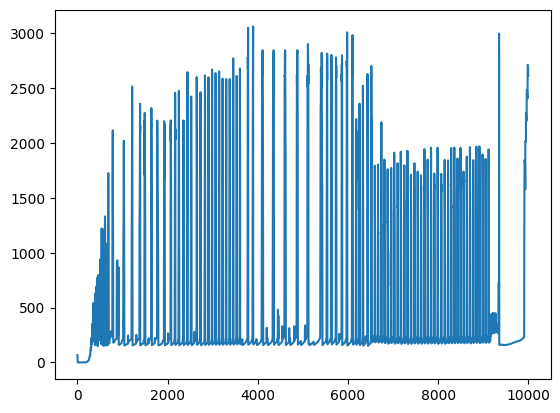

In [33]:
max_Qs_75 = np.array([max(values) for values in Qs_dict.values()])
time_75 = np.array(list(Qs_dict.keys()))

mask = time_75 <= 10000

time_75 = time_75[mask]
max_Qs_75 = max_Qs_75[mask]
plt.plot(time_75, max_Qs_75)
MAX_75 = np.max(max_Qs_75)

# MAX_21 = np.median(max_Qs_75)
print(MAX_75)

Grounding Line Plot - Amax = 8


In [34]:
gl_run_title_amax8 = str("Grounding Line Evolution Over Time - Max Accumulation = 8 m/yr")
amin16 = "/media/kayatroyer/KayaDrive/Thesis/OfficialExperimentRuns/20kTests/amin_tests/DATA_Dictionary_2025_05_03__02_07_22_amin16.pkl.gz"
with gzip.open(amin16, 'rb') as f:
    DATA_dict_amin16 = pickle.load(f)

In [35]:
bed_dict = DATA_dict_amin16['bed_dict']
base_dict = DATA_dict_amin16['base_dict']
surf_dict= DATA_dict_amin16['surf_dict']
sed_dict = DATA_dict_amin16['sed_dict']
H_dict = DATA_dict_amin16['H_dict']
us_dict_8 = DATA_dict_amin16['us_dict']
ub_dict_8 = DATA_dict_amin16['ub_dict']
Hs_dict = DATA_dict_amin16['Hs_dict']
GL_dict = DATA_dict_amin16['GL_dict']
Qs_dict_8 = DATA_dict_amin16['Qs_dict']

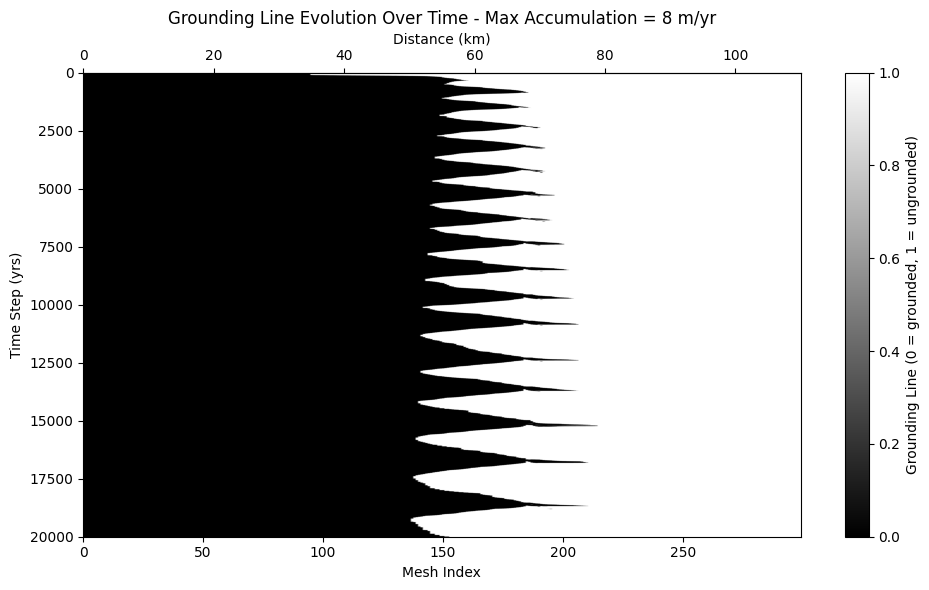

In [36]:
GL_dict = DATA_dict_amin16['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax8)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [37]:
gl_positions_amin16 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amin16.append(idx)

gl_positions_amin16 = np.array(gl_positions_amin16)
GL_km_amin16 = mesh_index_to_km(gl_positions_amin16)
mask = np.array(time) <= 10000
time = np.array(time)[mask]
GL_km_amin16 = GL_km_amin16[mask]


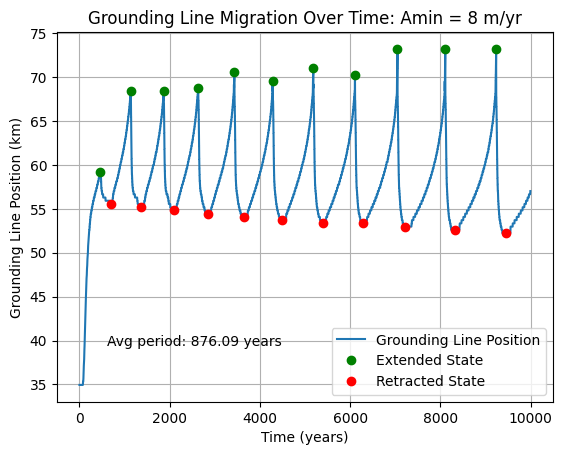

Mean cycle period: 876.09 years
[ 674.60801648  721.10593334  755.54657117  808.58369559  835.96918
  911.25251579  878.57957437  932.10549817 1105.41872961 1137.69453322]
Mean advance amplitude: 69.63 km
[59.23076923 68.42809365 68.42809365 68.79598662 70.63545151 69.53177258
 71.00334448 70.26755853 73.21070234 73.21070234 73.21070234]
Mean retreat amplitude: 53.85 km
[55.55183946 55.18394649 54.81605351 54.44816054 54.08026756 53.71237458
 53.34448161 53.34448161 52.97658863 52.60869565 52.24080268]


In [38]:
peaks_amin16, _ = find_peaks(GL_km_amin16, prominence=3) 
troughs_amin16, _ = find_peaks(-GL_km_amin16, prominence=3)     
periods_amin16 = np.diff(np.array(time)[troughs_amin16])
adv_dists_amin16 = GL_km_amin16[peaks_amin16]
ret_dists_amin16 = GL_km_amin16[troughs_amin16]


plt.plot(time, GL_km_amin16, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amin16], GL_km_amin16[peaks_amin16], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amin16], GL_km_amin16[troughs_amin16], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amin16):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amin = 8 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amin16):.2f} years")
print(periods_amin16)

print(f"Mean advance amplitude: {np.mean(adv_dists_amin16):.2f} km")
print(adv_dists_amin16)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amin16):.2f} km")
print(ret_dists_amin16)


3060.1516948897897


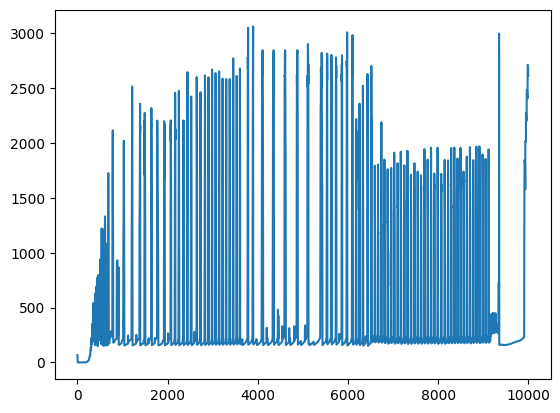

In [39]:
max_Qs_8 = np.array([max(values) for values in Qs_dict.values()])
time_8 = np.array(list(Qs_dict.keys()))

mask = time_8 <= 10000

time_8 = time_8[mask]
max_Qs_8 = max_Qs_8[mask]
plt.plot(time_8, max_Qs_8)
MAX_8 = np.max(max_Qs_8)

# MAX_21 = np.median(max_Qs_8)
print(MAX_8)

Grounding Line Plot - Amax = 8.5


In [40]:
gl_run_title_amax8_5 = str("Grounding Line Evolution Over Time - Max Accumulation = 8.5 m/yr")
amax8_5 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_20__21_38_02.pkl.gz"
with gzip.open(amax8_5, 'rb') as f:
    DATA_dict_amax8_5 = pickle.load(f)

In [41]:
bed_dict = DATA_dict_amax8_5['bed_dict']
base_dict = DATA_dict_amax8_5['base_dict']
surf_dict= DATA_dict_amax8_5['surf_dict']
sed_dict = DATA_dict_amax8_5['sed_dict']
H_dict = DATA_dict_amax8_5['H_dict']
us_dict_85 = DATA_dict_amax8_5['us_dict']
ub_dict_85 = DATA_dict_amax8_5['ub_dict']
Hs_dict = DATA_dict_amax8_5['Hs_dict']
GL_dict = DATA_dict_amax8_5['GL_dict']
Qs_dict_85 = DATA_dict_amax8_5['Qs_dict']

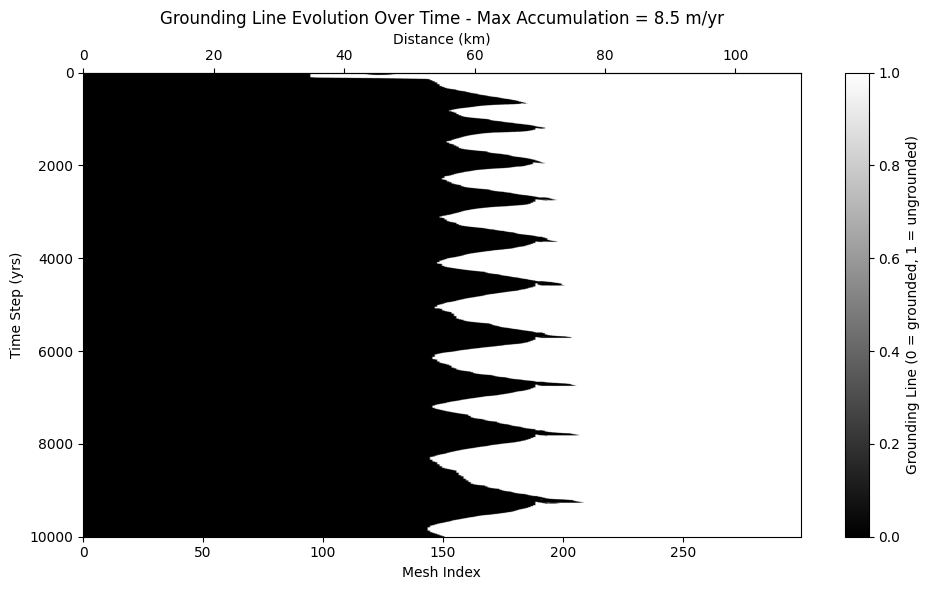

In [42]:
GL_dict = DATA_dict_amax8_5['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax8_5)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [43]:
gl_positions_amax8_5 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax8_5.append(idx)

gl_positions_amax8_5 = np.array(gl_positions_amax8_5)
GL_km_amax8_5 = mesh_index_to_km(gl_positions_amax8_5)



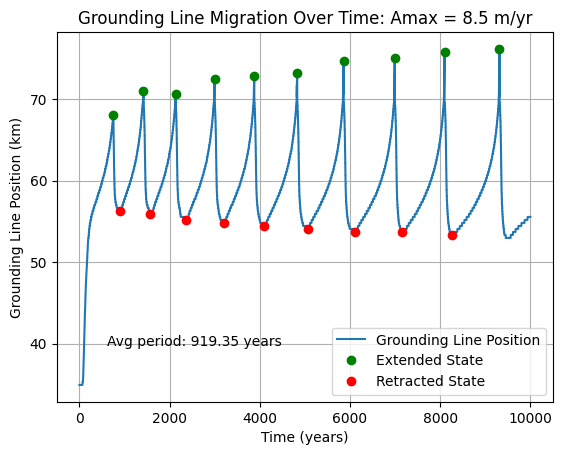

Mean cycle period: 919.35 years
[ 668.12237027  801.1793074   842.51219683  881.08740678  965.09881538
 1046.14914576 1058.25072057 1092.42289906]
Mean advance amplitude: 72.99 km
[68.06020067 71.00334448 70.63545151 72.47491639 72.84280936 73.21070234
 74.68227425 75.05016722 75.78595318 76.15384615]
Mean retreat amplitude: 54.61 km
[56.28762542 55.91973244 55.18394649 54.81605351 54.44816054 54.08026756
 53.71237458 53.71237458 53.34448161]


In [44]:
peaks_amax8_5, _ = find_peaks(GL_km_amax8_5, prominence=3) 
troughs_amax8_5, _ = find_peaks(-GL_km_amax8_5, prominence=3)     
periods_amax8_5 = np.diff(np.array(time)[troughs_amax8_5])
adv_dists_amax8_5 = GL_km_amax8_5[peaks_amax8_5]
ret_dists_amax8_5 = GL_km_amax8_5[troughs_amax8_5]


plt.plot(time, GL_km_amax8_5, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax8_5], GL_km_amax8_5[peaks_amax8_5], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax8_5], GL_km_amax8_5[troughs_amax8_5], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax8_5):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 8.5 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax8_5):.2f} years")
print(periods_amax8_5)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax8_5):.2f} km")
print(adv_dists_amax8_5)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax8_5):.2f} km")
print(ret_dists_amax8_5)


3060.1516948897897


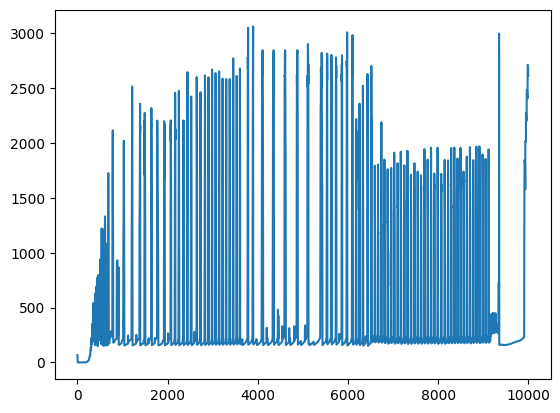

In [45]:
max_Qs_85 = np.array([max(values) for values in Qs_dict.values()])
time_85 = np.array(list(Qs_dict.keys()))

mask = time_85 <= 10000

time_85 = time_85[mask]
max_Qs_85 = max_Qs_85[mask]
plt.plot(time_85, max_Qs_85)
MAX_85 = np.max(max_Qs_85)

# MAX_21 = np.median(max_Qs_8)
print(MAX_85)

Grounding Line Plot - Amax = 9


In [46]:
gl_run_title_amax9 = str("Grounding Line Evolution Over Time - Max Accumulation = 9 m/yr")
amax9 = "/home/kayatroyer/Repositories/brinkmodeltest/Output/Variable_Dictionaries/DATA_Dictionary_2025_04_16__16_21_01.pkl.gz"
with gzip.open(amax9, 'rb') as f:
    DATA_dict_amax9 = pickle.load(f)

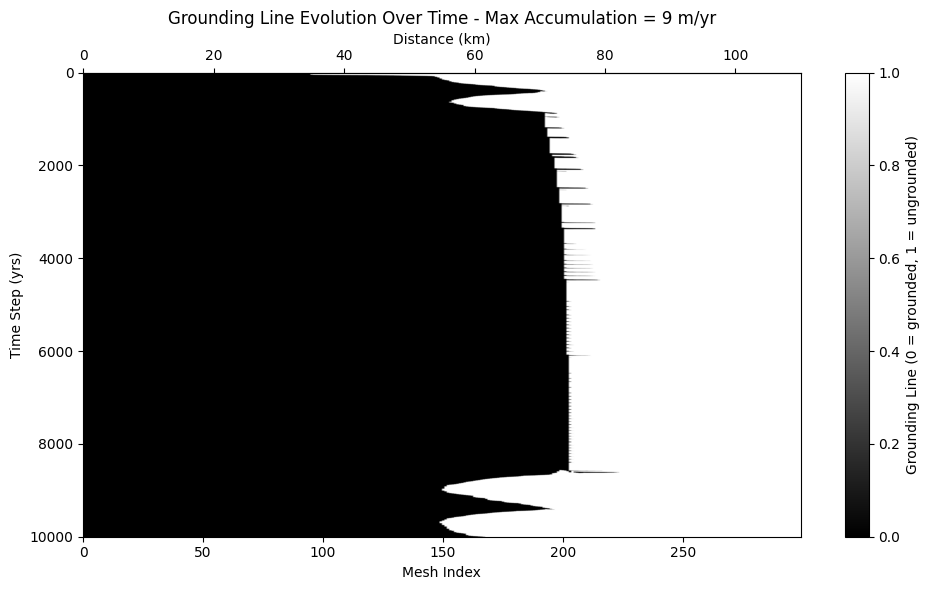

In [47]:
GL_dict = DATA_dict_amax9['GL_dict']
time = list(GL_dict.keys())
mesh_indices = np.arange(300)
data_matrix = np.array([GL_dict[t] for t in time])

fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(
    data_matrix, aspect='auto', cmap='gray', origin='lower',
    extent=[mesh_indices[0], mesh_indices[-1], time[0], time[-1]]
)

ax.set_ylabel("Time Step (yrs)")
ax.set_xlabel("Mesh Index")
ax.invert_yaxis()
plt.colorbar(im, ax=ax, label="Grounding Line (0 = grounded, 1 = ungrounded)")
ax.set_title(gl_run_title_amax9)

# Add secondary x-axis with length scale
secax = ax.secondary_xaxis('top', functions=(mesh_index_to_km, km_to_mesh_index))
secax.set_xlabel("Distance (km)")

plt.tight_layout()
plt.show()

In [48]:
gl_positions_amax9 = []
for row in data_matrix:
    idx = np.argmax(row > 0.5)
    gl_positions_amax9.append(idx)

gl_positions_amax9 = np.array(gl_positions_amax9)
GL_km_amax9 = mesh_index_to_km(gl_positions_amax9)



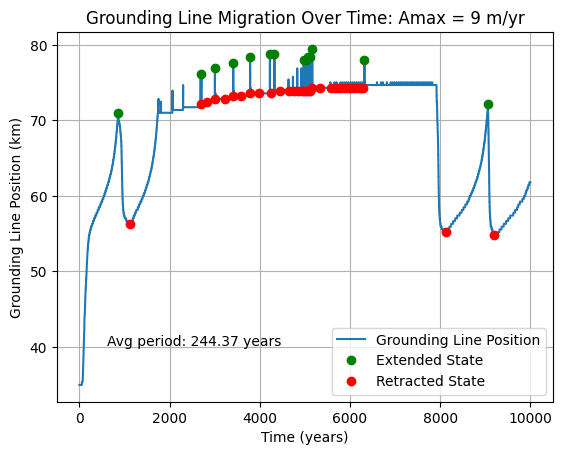

Mean cycle period: 244.37 years
[1561.82984111  132.550063    182.85534298  217.82305128  187.68959075
  161.91497236  212.24134298  195.41819835  264.08125915  203.58996626
  205.41515386   97.03205465   95.64149302   79.53395797   49.08362282
   47.58629719   48.35722759   46.88224017   45.43429884  168.64606426
  253.34254054   74.44460833   62.37727709   71.87280429   90.42179372
   88.69899958   45.20368251   86.9642744    87.69008904   42.56861397
   42.44312048 1854.39557458 1060.06769327]
Mean advance amplitude: 77.13 km
[71.00334448 76.15384615 76.88963211 77.62541806 78.36120401 78.72909699
 78.72909699 77.99331104 77.99331104 78.36120401 78.36120401 79.46488294
 77.99331104 72.10702341]
Mean retreat amplitude: 72.22 km
[56.28762542 72.10702341 72.47491639 72.84280936 72.84280936 73.21070234
 73.21070234 73.57859532 73.57859532 73.57859532 73.94648829 73.94648829
 73.94648829 73.94648829 73.94648829 73.94648829 73.94648829 73.94648829
 73.94648829 74.31438127 74.31438127 74.3

In [49]:
peaks_amax9, _ = find_peaks(GL_km_amax9, prominence=3, distance = 100) 
troughs_amax9, _ = find_peaks(-GL_km_amax9, prominence=3, distance = 100)     
periods_amax9 = np.diff(np.array(time)[troughs_amax9])
adv_dists_amax9 = GL_km_amax9[peaks_amax9]
ret_dists_amax9 = GL_km_amax9[troughs_amax9]


plt.plot(time, GL_km_amax9, label='Grounding Line Position')
plt.plot(np.array(time)[peaks_amax9], GL_km_amax9[peaks_amax9], 'go', label='Extended State')
plt.plot(np.array(time)[troughs_amax9], GL_km_amax9[troughs_amax9], 'ro', label='Retracted State')
plt.text(0.1, 0.15, f'Avg period: {np.mean(periods_amax9):.2f} years', transform=plt.gca().transAxes)
plt.legend()
plt.xlabel("Time (years)")
plt.ylabel("Grounding Line Position (km)")
plt.title("Grounding Line Migration Over Time: Amax = 9 m/yr")
plt.grid()
plt.show()

print(f"Mean cycle period: {np.mean(periods_amax9):.2f} years")
print(periods_amax9)

print(f"Mean advance amplitude: {np.mean(adv_dists_amax9):.2f} km")
print(adv_dists_amax9)

print(f"Mean retreat amplitude: {np.mean(ret_dists_amax9):.2f} km")
print(ret_dists_amax9)


3060.1516948897897


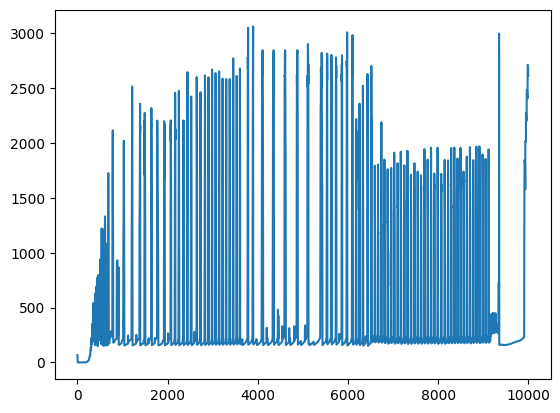

In [50]:
max_Qs_9 = np.array([max(values) for values in Qs_dict.values()])
time_9 = np.array(list(Qs_dict.keys()))

mask = time_9 <= 10000

time_9 = time_9[mask]
max_Qs_9 = max_Qs_9[mask]
plt.plot(time_9, max_Qs_9)
MAX_9 = np.max(max_Qs_9)

# MAX_21 = np.median(max_Qs_8)
print(MAX_9)

Genuinely appears to just sit at the second bump stable for 1000's of years, building a big moraine and eroding the bedrock in a different spot than other variables. Then it gets bumped off the moraine and retreats far back 

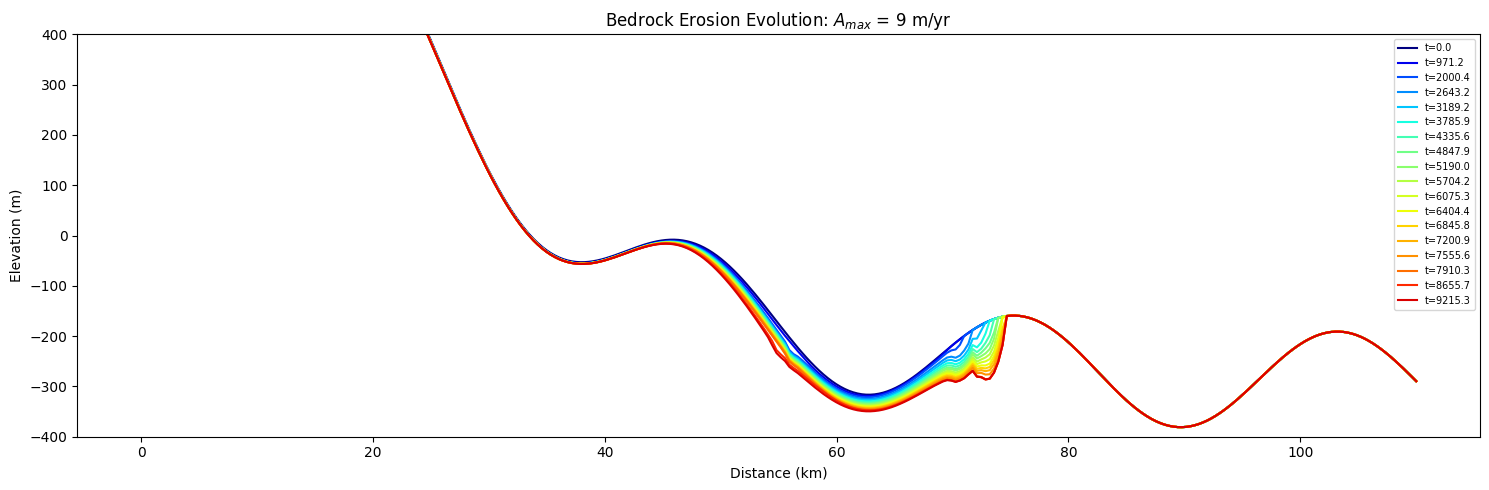

In [51]:
bed_dict = DATA_dict_amax9['bed_dict']
num_points = len(next(iter(bed_dict.values())))
x_km = mesh_index_to_km(np.arange(num_points))
time = list(bed_dict.keys())
# bed_profile = bed_dict[timesteps[0]] 
norm = plt.Normalize(min(time), max(time))
cmap = cm.jet

fig, ax1 = plt.subplots(figsize=(15,5))

for i, t in enumerate(time):
    if i % 800 != 0:  
        continue

    bed = bed_dict[t]
    color = cmap(norm(t))
    plt.plot(x_km, bed, color=color, label=f't={t:.1f}' if i % 25 == 0 else "")

plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Bedrock Erosion Evolution: $A_{max}$ = 9 m/yr")
# plt.gca().invert_xaxis() 
plt.legend(loc="upper right", fontsize=7)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# plt.xlim(30,100)
plt.ylim(-400,400)
# plt.colorbar(sm, label='Time (years)', ax=plt.gca())
# plt.axvline(x=0, color='gray', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()
# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/Results/ModelPlots/Amax/GL_Plots/Relationship_Plots/Bedrock_Evo_amax9.svg", format ="svg", bbox_inches='tight')

## Relationship Plots

In [52]:
title_amax_cycles = str("Cycle Frequency: Maximum Accumulation")
amaxs = np.array([6,6.5,7,7.5,8,8.5])
amax_cycles = np.array([13, 12, 13,12, 11,10])
amax_coeff = np.polyfit(amaxs,amax_cycles, 1)
p_amax = np.poly1d(amax_coeff)
amax_y_trend = p_amax(amaxs)
R_2_amax =r2_score(amax_cycles,p_amax(amaxs))


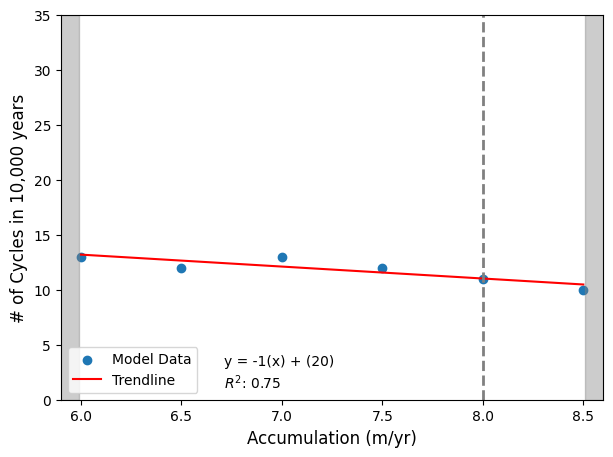

In [109]:
fig, ax1 = plt.subplots(figsize=(7,5))

# plt.title(title_amax_cycles, fontsize = 15)
plt.scatter(amaxs, amax_cycles, label = 'Model Data')
plt.plot(amaxs, amax_y_trend, color='red', label='Trendline')
ax1.axvspan(8.51, ax1.get_xlim()[1], color='gray', alpha=0.4)  
ax1.axvspan(ax1.get_xlim()[0], 5.99, color='gray', alpha=0.4) 
plt.text(0.3, 0.03, f'$R^2$: {R_2_amax:.2f}', transform=plt.gca().transAxes)
plt.text(0.3, 0.09, f'y = {amax_coeff[0]:.0f}(x) + ({amax_coeff[1]:.0f})', transform=plt.gca().transAxes)
plt.axvline(x=8, color='gray', linestyle='--', linewidth=2)
plt.xlabel("Accumulation (m/yr)", fontsize = 12)
plt.ylabel("# of Cycles in 10,000 years", fontsize =12)
plt.xticks(np.arange(6, 9, 0.5))
plt.xlim(5.9,8.6)
plt.ylim(0,35)
plt.legend(loc=3)

fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/Amax_Cycles_EQ.svg", format ="svg", bbox_inches='tight')

Variations in Cycle Period


In [129]:
amaxs = np.array([6,6.5,7,7.5,8, 8.5])

Period_list = [periods_amax6, periods_amax6_5, periods_amax7, periods_amax7_5, periods_amin16, periods_amax8_5]
medians = np.array([np.median(d) for d in Period_list])
print(f"medians:{medians}")
print(f"cfs{amaxs}")

medians:[742.44887894 781.7901545  757.55779847 856.13044522 857.27437719
 923.09311108]
cfs[6.  6.5 7.  7.5 8.  8.5]


In [130]:
CF_coeff = np.polyfit(amaxs,medians, 1)
p_CF = np.poly1d(CF_coeff)
CF_y_trend = p_CF(amaxs)
R_2_CF =r2_score(medians,p_CF(amaxs))

In [160]:
def inverse_model(x, b):
    return 10000 / (-x + b)

popt, _ = curve_fit(inverse_model, amaxs, medians, p0=[10])
b_fit = popt[0]

CF_y_trend = inverse_model(np.array(amaxs), b_fit)
R_2_CF = r2_score(medians, CF_y_trend)


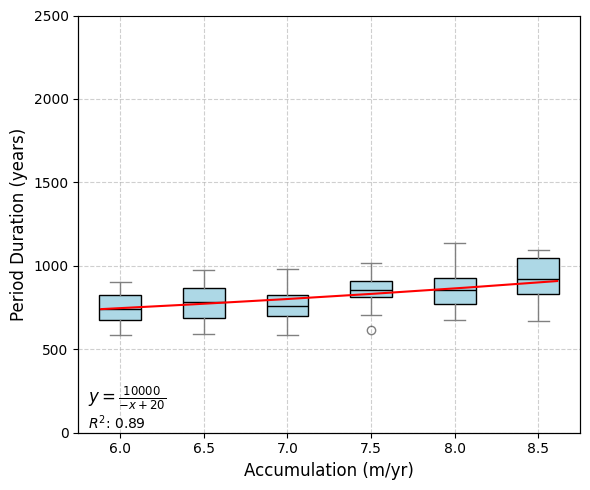

In [164]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(Period_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

# ax.set_title("Cycle Period Variations: Maximum Accumulation", fontsize = 15)
ax.set_ylabel("Period Duration (years)", fontsize = 12)
ax.set_xlabel("Accumulation (m/yr)", fontsize = 12)
ax.set_xticks(np.arange(1, len(amaxs) + 1))
ax.set_xticklabels(amaxs)
ax.set_ylim(0,2500)
ax.grid(True, linestyle='--', alpha=0.6)

ax1 = ax.twiny()
ax1.plot(amaxs, CF_y_trend, color='red', label='Trendline')
ax1.text(0.02, 0.07, f'$y = \\frac{{10000}}{{-x + {b_fit:.0f}}}$', transform=ax.transAxes, fontsize = 12)
ax1.text(0.02, 0.01, f'$R^2$: {R_2_CF:.2f}', transform=ax.transAxes)
ax1.set_xticks([])
ax1.set_xlabel("")
ax1.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()
fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/Amax_Period_EQ.svg", format ="svg", bbox_inches='tight')

Variations in GL Extent - Advance 

In [57]:
amaxs = np.array([6,6.5,7,7.5,8, 8.5])
ExtPos_list =  [adv_dists_amax6, adv_dists_amax6_5, adv_dists_amax7,adv_dists_amax7_5, adv_dists_amin16, adv_dists_amax8_5]
medians = np.array([np.median(d) for d in ExtPos_list])

adv_coeff = np.polyfit(amaxs,medians, 1)
p_adv = np.poly1d(adv_coeff)
adv_y_trend = p_adv(amaxs)
R_2_adv =r2_score(medians,p_adv(amaxs))

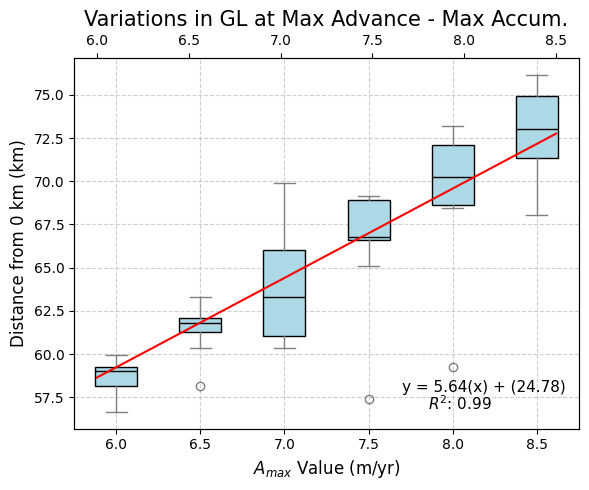

In [58]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(ExtPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Variations in GL at Max Advance - Max Accum.", fontsize = 15)
ax.set_ylabel("Distance from 0 km (km)", fontsize = 12)
ax.set_xlabel("$A_{max}$ Value (m/yr)", fontsize = 12)
ax.set_xticks(np.arange(1, len(amaxs) + 1))
ax.set_xticklabels(amaxs)
ax.grid(True, linestyle='--', alpha=0.6)

ax1 = ax.twiny()
ax1.plot(amaxs, adv_y_trend, color='red', label='Trendline')
ax1.text(0.7, 0.05, f'$R^2$: {R_2_adv:.2f}', transform=plt.gca().transAxes, fontsize =11)
ax1.text(0.65, 0.1, f'y = {adv_coeff[0]:.2f}(x) + ({adv_coeff[1]:.2f})', transform=plt.gca().transAxes, fontsize =11)

plt.tight_layout()
plt.show()

Variations in GL Extent - Retreat 

In [59]:
amaxs = np.array([6,6.5,7,7.5,8,8.5])
RetPos_list =  [ret_dists_amax6, ret_dists_amax6_5, ret_dists_amax7, ret_dists_amax7_5,  ret_dists_amin16, ret_dists_amax8_5]
medians = np.array([np.median(d) for d in RetPos_list])

ret_coeff = np.polyfit(amaxs,medians, 1)
p_ret = np.poly1d(ret_coeff)
ret_y_trend = p_ret(amaxs)
R_2_ret =r2_score(medians,p_ret(amaxs))


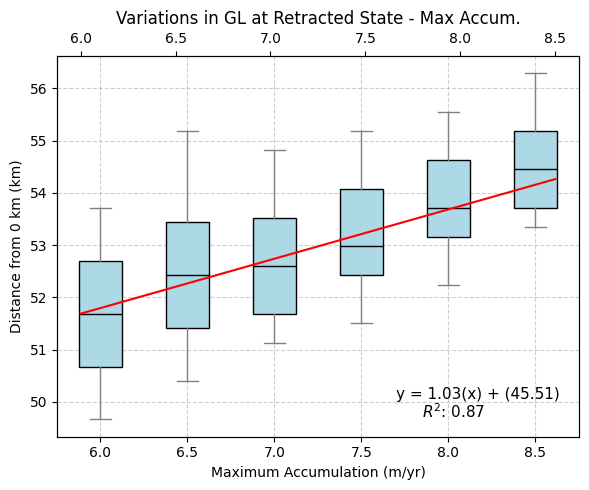

In [60]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.boxplot(RetPos_list, patch_artist=True,
           boxprops=dict(facecolor='lightblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='gray'),
           capprops=dict(color='gray'),
           flierprops=dict(marker='o', color='red', alpha=0.5))

ax.set_title("Variations in GL at Retracted State - Max Accum.")
ax.set_ylabel("Distance from 0 km (km)")
ax.set_xlabel("Maximum Accumulation (m/yr)")
ax.set_xticks(np.arange(1, len(amaxs) + 1))
ax.set_xticklabels(amaxs)
ax.grid(True, linestyle='--', alpha=0.6)

ax1 = ax.twiny()
ax1.plot(amaxs, ret_y_trend, color='red', label='Trendline')
ax1.text(0.7, 0.05, f'$R^2$: {R_2_CF:.2f}', transform=plt.gca().transAxes, fontsize =11)
ax1.text(0.65, 0.1, f'y = {ret_coeff[0]:.2f}(x) + ({ret_coeff[1]:.2f})', transform=plt.gca().transAxes, fontsize =11)
plt.tight_layout()
plt.show()

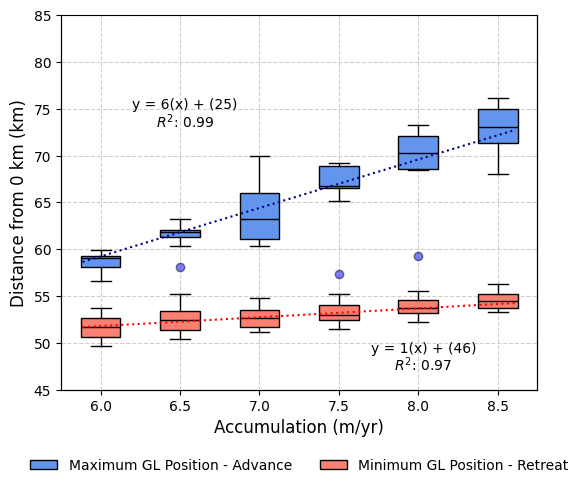

In [76]:
fig, ax = plt.subplots(figsize=(6, 5))

D2 = ax.boxplot(RetPos_list, patch_artist=True,
           boxprops=dict(facecolor='salmon'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           flierprops=dict(marker='o', markerfacecolor='salmon', alpha=0.5))

D1 = ax.boxplot(ExtPos_list, patch_artist=True,
           boxprops=dict(facecolor='cornflowerblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           flierprops=dict(marker='o', markerfacecolor='blue', alpha=0.5))

# ax.set_title("Grounding Line Variation: Maximum Accumulation", fontsize = 12)
ax.set_ylabel("Distance from 0 km (km)", fontsize = 12)
ax.set_xlabel("Accumulation (m/yr)", fontsize = 12)
ax.legend([D1["boxes"][0], D2["boxes"][0]], ['Maximum GL Position - Advance', 'Minimum GL Position - Retreat'], loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=2, frameon=False)
ax.set_xticks(np.arange(1, len(amaxs) + 1))
ax.set_xticklabels(amaxs)
ax.set_ylim(45,85)
ax.grid(True, linestyle='--', alpha=0.6)

ax1 = ax.twiny()
ax1.plot(amaxs, adv_y_trend, color='darkblue', linestyle = 'dotted', label='Trendline')
ax1.plot(amaxs, ret_y_trend, color='red', linestyle = 'dotted', label='Trendline')
#advance equation
ax1.text(0.2, 0.7, f'$R^2$: {R_2_adv:.2f}', transform=plt.gca().transAxes)
ax1.text(0.15, 0.75, f'y = {adv_coeff[0]:.0f}(x) + ({adv_coeff[1]:.0f})', transform=plt.gca().transAxes)

#retreat equation
ax1.text(0.7, 0.05, f'$R^2$: {R_2_ret:.2f}', transform=plt.gca().transAxes)
ax1.text(0.65, 0.1, f'y = {ret_coeff[0]:.0f}(x) + ({ret_coeff[1]:.0f})', transform=plt.gca().transAxes)

ax1.set_xticks([])
ax1.set_xlabel("")
ax1.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()
fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/Amax_GL_EQ.svg", format ="svg", bbox_inches='tight')

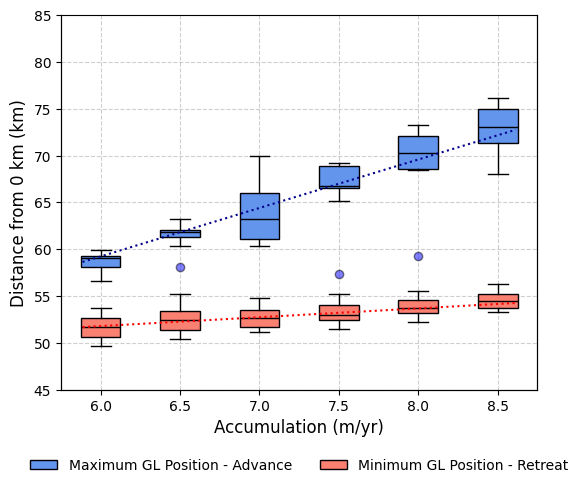

In [77]:
fig, ax = plt.subplots(figsize=(6, 5))

D2 = ax.boxplot(RetPos_list, patch_artist=True,
           boxprops=dict(facecolor='salmon'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           flierprops=dict(marker='o', markerfacecolor='salmon', alpha=0.5))

D1 = ax.boxplot(ExtPos_list, patch_artist=True,
           boxprops=dict(facecolor='cornflowerblue'),
           medianprops=dict(color='black'),
           whiskerprops=dict(color='black'),
           capprops=dict(color='black'),
           flierprops=dict(marker='o', markerfacecolor='blue', alpha=0.5))

# ax.set_title("Grounding Line Variation: Maximum Accumulation", fontsize = 12)
ax.set_ylabel("Distance from 0 km (km)", fontsize = 12)
ax.set_xlabel("Accumulation (m/yr)", fontsize = 12)
ax.legend([D1["boxes"][0], D2["boxes"][0]], ['Maximum GL Position - Advance', 'Minimum GL Position - Retreat'], loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=2, frameon=False)
ax.set_xticks(np.arange(1, len(amaxs) + 1))
ax.set_xticklabels(amaxs)
plt.ylim(45,85)
ax.grid(True, linestyle='--', alpha=0.6)

ax1 = ax.twiny()
ax1.plot(amaxs, adv_y_trend, color='darkblue', linestyle = 'dotted', label='Trendline')
ax1.plot(amaxs, ret_y_trend, color='red', linestyle = 'dotted', label='Trendline')
ax1.set_xticks([])
ax1.set_xlabel("")
ax1.spines['top'].set_visible(False)

plt.tight_layout()
plt.show()
fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/Amax_GL.svg", format ="svg", bbox_inches='tight')

In [63]:
surf_vels =[us_dict_6,us_dict_65, us_dict_7, us_dict_75, us_dict_8, us_dict_85]
# surf_vels =[us_dict_14, us_dict_16, us_dict_18, us_dict_20]


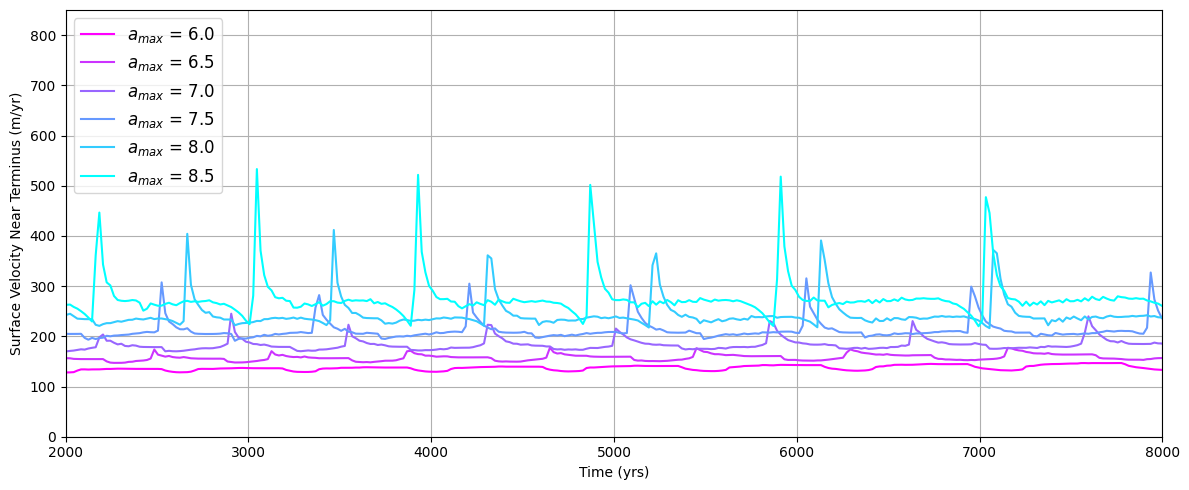

In [85]:
from scipy.interpolate import interp1d

common_times = np.linspace(0, 10000, 500)
cmap = plt.colormaps['cool_r']
colors = cmap(np.linspace(0, 1, len(surf_vels)))

fig, ax = plt.subplots(figsize=(12, 5))

for i, us_dict in enumerate(surf_vels):
    term_surface_velocity = []
    times = []

    for t in sorted(us_dict.keys()):
        us_ = us_dict[t]
        notNAN = np.where(np.isfinite(us_))[0]

        if len(notNAN) > 0:
            terminus = notNAN[-1]
        else:
            terminus = None

        if terminus is not None and terminus >= 50:
            term_usvel = us_[terminus - 50]
        else:
            term_usvel = 0

        if np.isnan(term_usvel):
            term_usvel = 0

        term_surface_velocity.append(term_usvel)
        times.append(t)

    times = np.array(times)
    term_surface_velocity = np.array(term_surface_velocity)

    # Sort for interpolation
    sorted_indices = np.argsort(times)
    times = times[sorted_indices]
    term_surface_velocity = term_surface_velocity[sorted_indices]

    # Interpolate to common time grid
    interp_func = interp1d(times, term_surface_velocity, bounds_error=False, fill_value="extrapolate")
    interp_speeds = interp_func(common_times)

    plt.plot(common_times, interp_speeds, label=f'$a_{{max}}$ = {6+i/2}', color=colors[i])

plt.xlabel('Time (yrs)')
plt.ylabel('Surface Velocity Near Terminus (m/yr)')
plt.legend(loc = 2, fontsize = 12)
# plt.title('Surface Velocities: Tested $a_{max}$ Values')
plt.xlim(2000,8000)
plt.ylim(0,850)

plt.grid(True)
plt.tight_layout()
plt.show()
fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/Amax_VEL.svg", format ="svg", bbox_inches='tight')

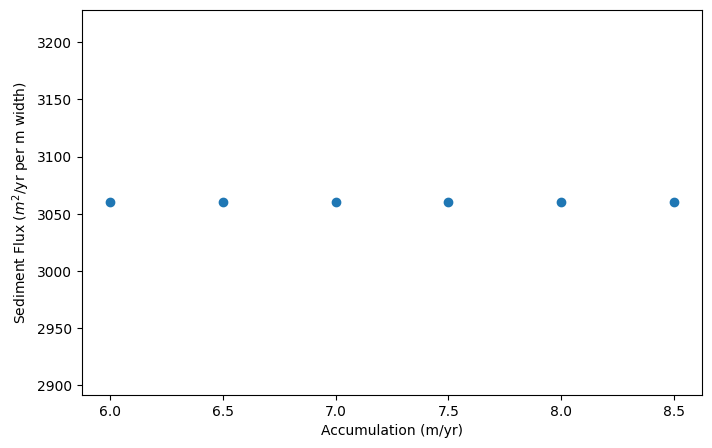

In [88]:
amaxs = np.array([6,6.5,7,7.5,8,8.5])
maxs_Qs = np.array([MAX_6, MAX_65, MAX_7, MAX_75, MAX_8, MAX_85])
CF_coeff = np.polyfit(amaxs,maxs_Qs, 1)
p_CF = np.poly1d(CF_coeff)
CF_y_trend = p_CF(amaxs)
R_2_CF =r2_score(maxs_Qs,p_CF(amaxs))

fig, ax = plt.subplots(figsize=(8, 5))

plt.scatter(amaxs, maxs_Qs, label = 'Model Output')
# plt.plot(amaxs, CF_y_trend, color='red', label='Trendline')
# plt.text(0.25, 0.9, f'$R^2$: {R_2_CF:.2f}', transform=plt.gca().transAxes)
# plt.text(0.2, 0.95, f'y = {CF_coeff[0]:.2f}(x) + ({CF_coeff[1]:.2f})', transform=plt.gca().transAxes)
plt.xlabel("Accumulation (m/yr)")
plt.ylabel("Sediment Flux ($m^{2}$/yr per m width)")
# plt.title("Accumulation Effect on Sediment Flux")
# plt.legend()
plt.show()
# fig.savefig("/media/kayatroyer/KayaDrive/Thesis/Figures/FinalFigures/Amax_QS.svg", format ="svg", bbox_inches='tight')